Classificação:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       267
           1       0.99      1.00      1.00       233

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



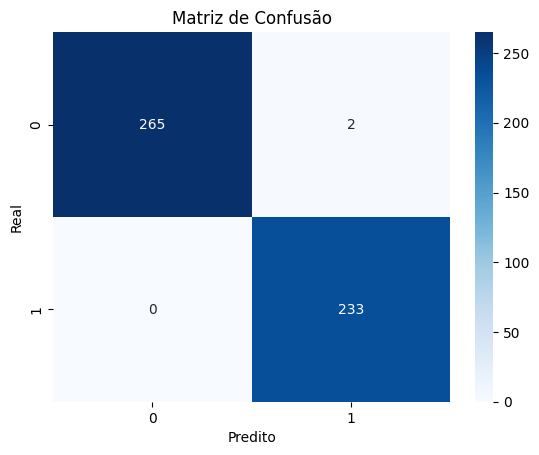

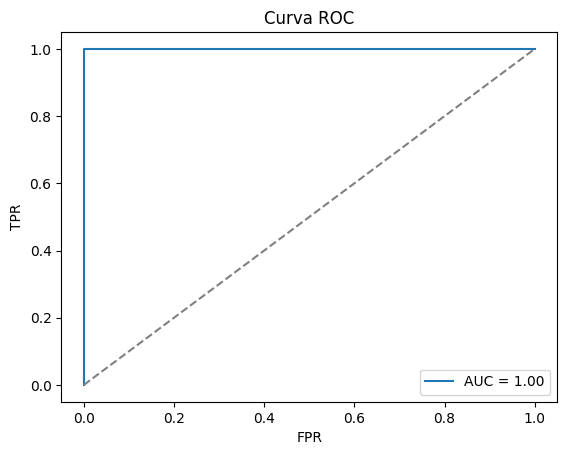

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns


#Carregando os dados já tratados em arquivos csv (poderia ser do DW sem problemas, é literalmente a mesma coisa)

df = pd.read_csv("dados_tratados/fato_final_aluno.csv")


#Criando a risco de evasão (é um tipo binário)

df["risco_evasao"] = np.where(
    (df["semanas_presentes"] <= 4) |
    (df["media_nota"] < 3) |
    (df["total_avaliacoes"] == 0),
    1, 0
)


#Selecionando as features e tratando os valores ausentes pra não dar b.o mais tarde

features = [
    "idade", "semanas_presentes", "media_nota", "total_feedbacks",
    "peso_inicial", "peso_final", "perda_peso",
    "ganho_forca", "total_avaliacoes"
]

df_modelo = df[features + ["risco_evasao"]].copy()
df_modelo = df_modelo.fillna(0)  # substitui NaN por 0


#Separando os dados em treino e teste (padrão)

X = df_modelo.drop("risco_evasao", axis=1)
y = df_modelo["risco_evasao"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


#Treinando o modelo de classificação (a mágica acontecendo rsrs)

modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)


#Avaliando o desempenho do meu modelo

y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)[:, 1]

print("Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Crva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


In [2]:
#Contagem de alunos classificados como risco de uma evasão
print("Distribuição de risco:")
print(df_modelo['risco_evasao'].value_counts())

#Porcentagem
print("\nPorcentagem:")
print(df_modelo['risco_evasao'].value_counts(normalize=True) * 100)

Distribuição de risco:
risco_evasao
0    1117
1     883
Name: count, dtype: int64

Porcentagem:
risco_evasao
0    55.85
1    44.15
Name: proportion, dtype: float64


In [3]:
#Características dos alunos em risco de evasão
alunos_risco = df[df['risco_evasao'] == 1]
print("\nCaracterísticas médias dos alunos em risco:")
print(alunos_risco[features].mean())

#Comparação com alunos sem risco de evasão
alunos_seguros = df[df['risco_evasao'] == 0]
print("\nComparação com alunos sem risco:")
print(alunos_seguros[features].mean())


Características médias dos alunos em risco:
idade                41.761042
semanas_presentes    10.180068
media_nota            2.424334
total_feedbacks       5.941110
peso_inicial         84.378136
peso_final           84.923015
perda_peso           -0.544879
ganho_forca           0.628308
total_avaliacoes      4.081703
dtype: float64

Comparação com alunos sem risco:
idade                41.484333
semanas_presentes    10.619517
media_nota            3.442227
total_feedbacks       6.062837
peso_inicial         86.140967
peso_final           85.316606
perda_peso            0.824361
ganho_forca           3.386861
total_avaliacoes      4.062956
dtype: float64


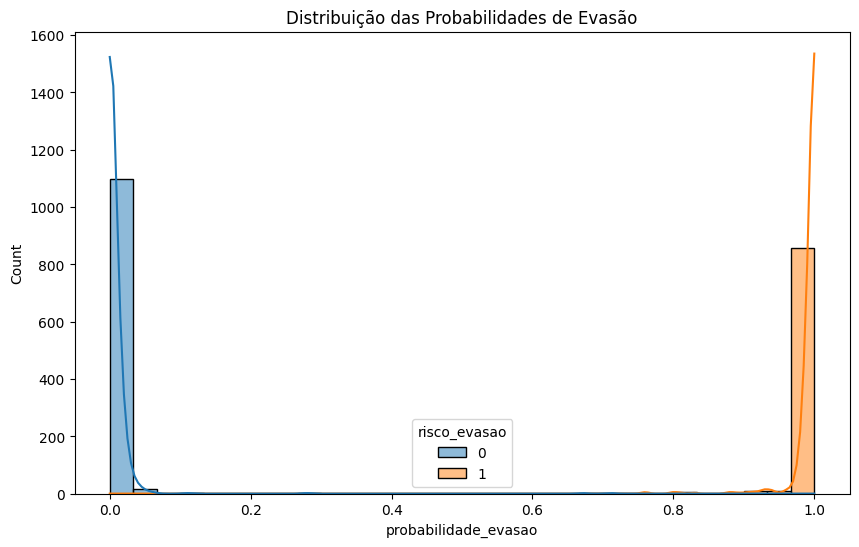

In [4]:
#Adicionando a probabilidade de evasão ao DF original
df['probabilidade_evasao'] = modelo.predict_proba(df_modelo[features])[:,1]

#Analisando a distribuição das probabilidades
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='probabilidade_evasao', hue='risco_evasao', bins=30, kde=True)
plt.title('Distribuição das Probabilidades de Evasão')
plt.show()

In [5]:
#Classificação 
df['nivel_risco'] = pd.cut(df['probabilidade_evasao'],
                          bins=[0, 0.3, 0.7, 1],
                          labels=['Baixo', 'Médio', 'Alto'])

#Visualizando a distribuição
print("\nDistribuição por nível de risco:")
print(df['nivel_risco'].value_counts())

#Exportar uma lista de alunos com prioridades e risco de evasão para um arquivo CSV
df[['nome', 'probabilidade_evasao', 'nivel_risco']].sort_values(
    'probabilidade_evasao', ascending=False).to_csv('alunos_priorizados.csv', index=False)


Distribuição por nível de risco:
nivel_risco
Alto     884
Baixo    327
Médio      1
Name: count, dtype: int64
